In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [2]:
# Посмотрим тип данных и содержание каждого столбца, для этого применим к датафрейму метод info():

ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [3]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [4]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %

In [6]:
daily_data['conversion'] = daily_data['converted'] / daily_data['users_count'] * 100
daily_data.head(10)

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361
5,2017-01-04,B,6538,763,11.670236
6,2017-01-05,A,6419,791,12.322792
7,2017-01-05,B,6509,743,11.414964
8,2017-01-06,A,6604,762,11.538462
9,2017-01-06,B,6735,834,12.383073


Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

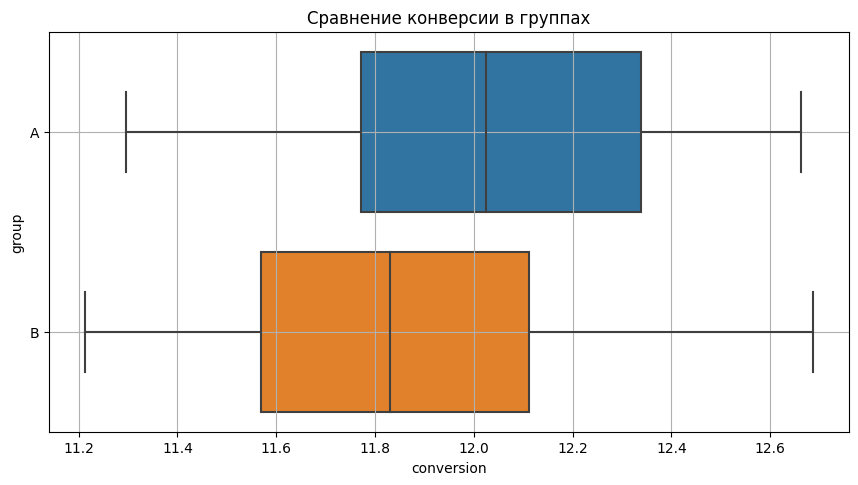

In [7]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid(True);

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [8]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

?Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

**Примечание. Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.**

Тут нам помогут кумулятивные метрики.

**Кумулятивная метрика** — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

C самого начала любой из вариантов может показывать лучшие результаты, и статистическая значимость может быть достигнута уже в первые дни теста. Это явление называется **проблемой подглядывания**.

Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

То есть в начале теста любой полученный за день результат будет оказывать сильное влияние на результат теста. Но со временем данные будут накапливаться, и доля получаемых за день данных будет всё меньше и меньше воздействовать на уже накопленный результат. 

Примечание. Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую.

Важно! Принимать какие-либо решения стоит только после того, как метрика стабилизируется!

Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему. 

Примечание. В качестве кумулятивной метрики можно считать не только конверсию, но и выручку, средний чек, количество заказов, процент негативных комментариев, точность модели и так далее.

Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график. 

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.9/

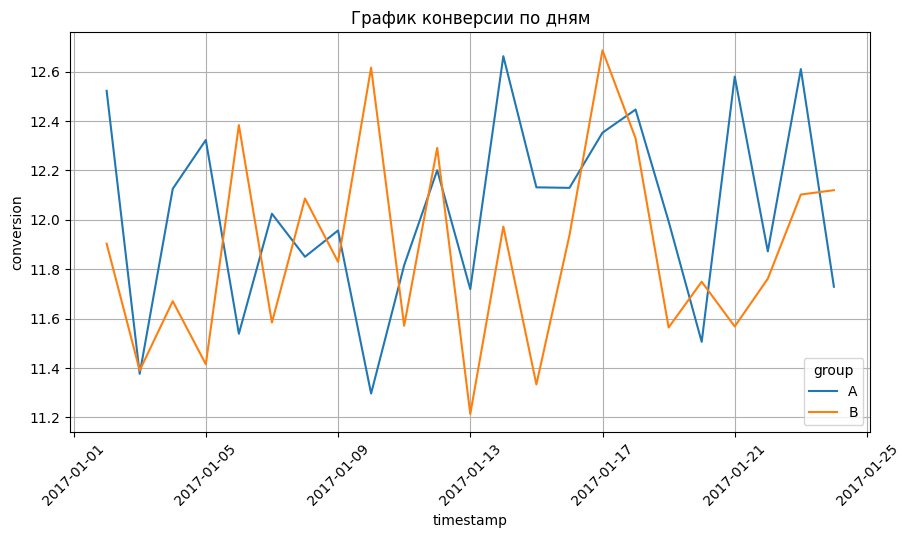

In [9]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [10]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

/var/folders/jr/y6j710014w98cjhsh00zh_gw0000gn/T/ipykernel_33104/906787284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [11]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.9/

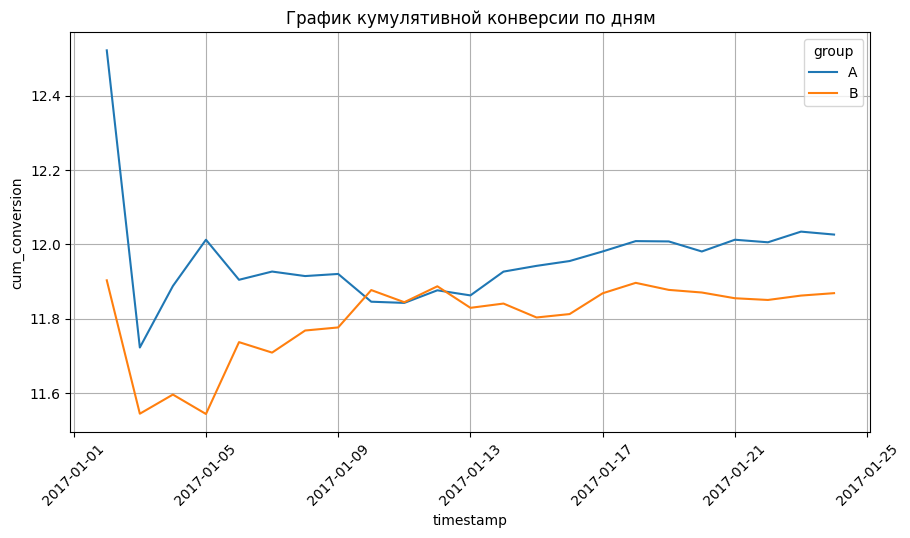

In [12]:
# А теперь построим графики кумулятивной конверсии по дням в каждой группе:

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

⭐️ Значит, мы можем переходить к проведению статистических тестов. 

# Задачи 4.6 - 4.9

In [13]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

Задание 4.6

Постройте таблицу со следующими ежедневными показателями:
- количество посетителей сайта;
- суммарное число транзакций;
- общая сумма покупок (выручка).

Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.

Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?

In [16]:
# преобразуем тип столбца date к типу datetime
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')
sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

In [19]:
# группируем данные по дате и рассчитываем агрегированные  показатели в группе А
daily_sample_a = sample_a.groupby('date').agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum',
}).reset_index()
# группируем данные по дате и рассчитываем агрегированные  показатели в группе B
daily_sample_b = sample_b.groupby('date').agg({
    'cid': 'count',
    'transactions': 'sum',
    'revenue': 'sum',
}).reset_index()
print(daily_sample_a[daily_sample_a['date'] == pd.to_datetime('2020-11-08')])

        date   cid  transactions  revenue
2 2020-11-08  3354            25   846051


Задание 4.7

Добавьте в каждую из таблиц кумулятивные метрики:
- кумулятивное количество посетителей сайта;
- кумулятивное суммарное число транзакций;
- кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

In [20]:
# объявляем функцию для расчёта кумулятивных показателей
def calculate_cum(data):
    data['cum_users_count'] = data['cid'].cumsum()
    data['cum_transactions'] = data['transactions'].cumsum()
    data['cum_revenue'] = data['revenue'].cumsum()
    data['cum_conversion'] = data['cum_transactions']/data['cum_users_count'] * 100
    data['cum_mean_check'] = data['cum_revenue']/data['cum_transactions']
    return data
# применяем функцию для каждого набора данных:
daily_sample_a = calculate_cum(daily_sample_a)
daily_sample_b = calculate_cum(daily_sample_b)
# вычислим среднюю кумулятивную конверсию в каждой группе
print(round(daily_sample_a['cum_conversion'].mean(), 2))
print(round(daily_sample_b['cum_conversion'].mean(), 2))

0.71
0.76


In [21]:
daily_sample_a.head()

,date,cid,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_mean_check
0,2020-11-06,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-07,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
2,2020-11-08,3354,25,846051,8634,64,4145216,0.741256,64769.000000
3,2020-11-09,3234,18,708830,11868,82,4854046,0.690934,59195.682927
4,2020-11-10,3022,29,826984,14890,111,5681030,0.745467,51180.450450


Задание 4.8

Постройте графики кумулятивной конверсии в каждой группе. Какие выводы по ним вы можете сделать?

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py

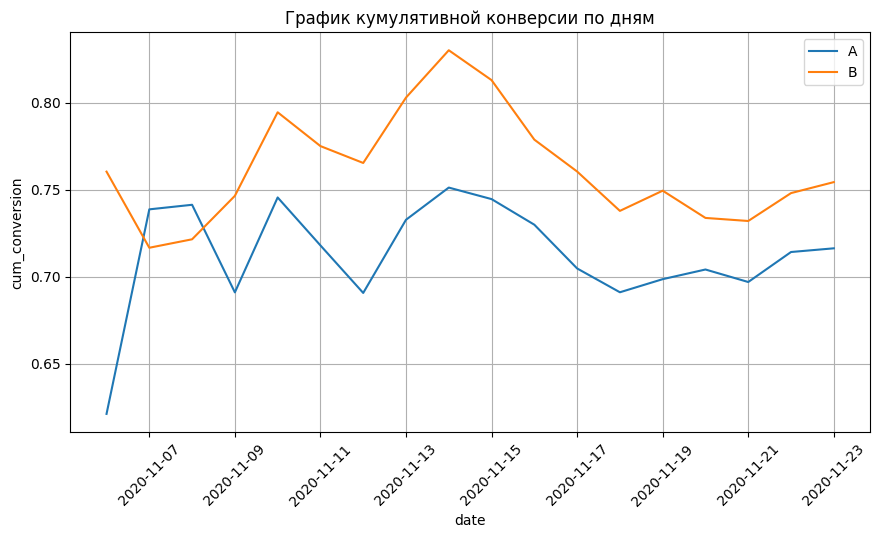

In [23]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_sample_a, ax=ax, label='A')
sns.lineplot(x='date', y='cum_conversion', data=daily_sample_b, ax=ax, label='B')
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
#задаём отображение сетки
ax.grid(True);

Задание 4.9

Постройте графики кумулятивного среднего чека в каждой группе. Какие выводы по ним вы можете сделать?

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py

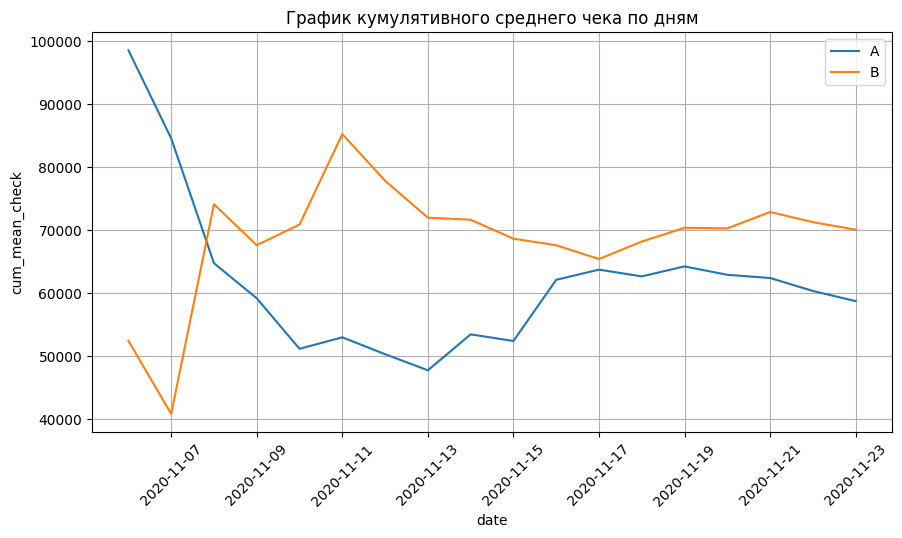

In [24]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily_sample_a, ax=ax, label='A')
sns.lineplot(x='date', y='cum_mean_check', data=daily_sample_b, ax=ax, label='B')
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

# 5. Анализ результатов A/B-тестирования: статистические тесты

Вернёмся к нашей задаче об оценке разницы конверсий действия «Добавить товар в корзину» для двух вариантов рекомендательных систем.

Сначала подготовим данные к проведению статистических тестов. Для этого нам нужно рассчитать количество пользователей, совершивших конверсию, и общее количество пользователей в каждой контрольной и тестовой группах.

Cгруппируем таблицу ab_data по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы:

In [26]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Мы знаем, что группы независимые: пользователи в группах А и B не пересекаются. Значит, нам нужно воспользоваться либо Z- либо ХИ2-критерием. Давайте рассмотрим тонкости применения обоих критериев.

In [27]:
# Z-тест для пропорций реализован в функции proportions_ztest() модуля proportion библиотеки statsmodels. Импортируем его:

from statsmodels.stats.proportion import proportions_ztest

Для получения p-value необходимо передать в функцию следующие аргументы:

- count — количество «успехов» (в каждой из групп). В данном случае это количество пользователей, которые совершили целевое действие в каждой группе.
- nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
- alternative — вид альтернативной гипотезы ('two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя). По умолчанию параметр равен 'two-sided'.
- value — число, с которым сравнивается разница между двумя пропорциями. По умолчанию равно 0.

Примечание. Этот параметр может пригодиться, если необходимо проверить разницу между пропорциями на соответствие конкретному числу: например, гипотезы вида «Конверсия в группе A меньше, чем конверсия в группе B на 3 %». Тогда в качестве значения value можно установить число 0.03.

Примечание. Давайте вспомним, что:
- Если полученное значение p-value ниже уровня значимости (), это означает, что результаты статистически значимы и согласуются с альтернативной гипотезой.
- Если полученное значение p-value выше уровня значимости (), результаты считаются статистически незначимыми и нельзя отвергнуть нулевую гипотезу.

In [28]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


Итак, мы получили p-value = 0.19. Это больше, чем заданный уровень значимости 0.05, а значит, мы должны принять нулевую гипотезу о равенстве конверсий.

Что это значит для нас и для бизнеса?

Так как Z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза не подтверждается статистически.

Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии.
На основе этого вывода мы принимаем решение о том, что делать дальше.

Возможные варианты:
- отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить текущую версию рекомендаций;
- попытаться усовершенствовать модель и провести тестирование снова;
- использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

А что, если мы хотим уточнить исследование и проверить гипотезу о том, что варианты А и B не просто идентичны между собой, а вариант А даже лучше варианта B по метрике конверсии? Тогда нам нужно переформулировать гипотезы таким образом, чтобы альтернативная гипотеза отражала наш бизнес-вопрос:
- Нулевая (будет задавать отсутствие эффекта): конверсия в группе А меньше либо равна конверсии в группе B.
- Альтернативная (будет задавать наличие эффекта): конверсия в группе А больше, чем конверсия в группе B.

In [29]:
# Тогда код будет выглядеть следующим образом:

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя альтернативная гипотеза
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.095
У нас нет оснований отвергнуть нулевую гипотезу


Итак, p-value = 0.095 вновь больше, чем уровень значимости 0.05. А значит, что статистика говорит нам о том, что вариант A все таки не лучше, чем вариант B, что, в принципе, было ожидаемым из предыдущего тестирования о равенстве конверсий.

### ХИ2-ТЕСТ ДЛЯ ПРОПОРЦИЙ

Теперь давайте воспользуемся  ХИ2-тестом для оценки разницы в пропорциях.

Этот тест основан на уже знакомом нам ХИ2-критерии, который мы применяли для тестирования гипотезы о независимости двух категориальных признаков. Оказывается, этот же критерий с небольшими модификациями можно использовать и для установления статистической значимости разницы между пропорциями.

Этот тест применяется только для двусторонних гипотез:
- Нулевая гипотеза: разница пропорций в группах A и B равна некоторому заранее заданному числу V
- Альтернативная гипотеза: разница пропорций в группах A и B отлична от числа V

По умолчанию V=0, соответственно, проверяется нулевая гипотеза равенства между истинными пропорциями против альтернативной гипотезы об их неравенстве.

Тестом не предусмотрена возможность проверки односторонних гипотез.

ХИ2-тест для пропорций реализован в функции proportions_chisquare() модуля proportion библиотеки statsmodels. Импортируем его:

In [30]:
from statsmodels.stats.proportion import proportions_chisquare

Для получения ХИ2-статистики и p-value необходимо передать в функцию следующие аргументы:
- count — количество «успехов» (в каждой из групп). В данном случае это количество пользователей, которые совершили целевое действие в каждой группе.
- nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
- value — число, с которым сравнивается разница между двумя пропорциями. По умолчанию равно 0.

Давайте применим -тест для пропорций на примере двух типов рекомендаций интернет-магазина с параметром value=0. То есть у нас будут две следующие конкурирующие гипотезы:
- Нулевая (будет задавать отсутствие эффекта): конверсии в группах A и B равны.
- Альтернативная (будет задавать наличие эффекта): конверсии в группах A и B не равны.

По умолчанию функция proportions_chisquare() возвращает -статистику, p-value и таблицу сопряжённости (используется во внутренних расчётах p-value). Из всего перечня возвращаемых значений нас интересует только p-value. Занесём его в отдельную переменную для дальнейшего сравнения с уровнем значимости.

Зададим уровень значимости 0.05 и будем сравнивать с ним полученное p-value.

In [32]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'] #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.19
У нас нет оснований отвергнуть нулевую гипотезу


СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ ДРУГИХ МЕТРИК

На самом деле наша задача об оценке эффективности двух вариантов была сильно упрощена: мы рассматривали только одну метрику — конверсию добавления в корзину. В реальности смотрят на несколько показателей в комплексе.

Помимо конверсии (категориальной метрики), нужно рассматривать и другие, числовые метрики, например средний чек. Ведь возможно такое, что конверсия в группах одинаковая, а средние чеки существенно различаются. 

В таком случае проводят статистические тесты для обеих метрик и принимают решение в пользу варианта, который эффективнее по более приоритетной метрике (например, если мы хотим повысить прибыль, это будет средний чек).

Что делать с другими метриками?

То же самое: провести визуальный анализ показателей, посмотреть на кумулятивные графики, убедиться в достаточном накопительном эффекте, после чего провести статистический тест (построить доверительный интервал, речь о котором пойдёт далее) и определить статистическую значимость разницы в показателях.
Однако стоит помнить о том, что любой статистический метод имеет свою область применения, которая зависит от задачи и распределения данных. Перед тем как проводить статистический тест, важно узнать распределение метрики, по которой вы будете сравнивать.

Например, время, проведённое на сайте, часто бывает нормально распределённым. Тогда мы можем использовать двухвыборочный T-критерий для средних. А вот денежные метрики, такие как средний чек, часто (но не всегда) напоминают логнормальное распределение: большинство наблюдений сосредоточены около нуля, и частота постепенно падает.

Напомним, что для проверки распределения на нормальность мы всегда можем воспользоваться самым популярным и знакомым нам тестом Шапиро — Уилка или любым другим, например, тестом Д’Агостино

#### ПАРАМЕТРИЧЕСКИЕ ТЕСТЫ

Давайте рассмотрим пример.

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательна для посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 0.05.

Прочитаем его:

In [33]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


In [34]:
# Для начала сравним среднее время в группах на глаз. Рассчитаем среднее и медианное время в каждой группе:

time_data[['time(A)', 'time(B)']].agg(['mean', 'median'])

,time(A),time(B)
mean,492.90,595.406667
median,482.25,600.400000


По предварительным подсчётам, среднее время, проводимое на сайте, в группе B выше, чем в группе A. Однако делать выводы ещё рано — необходимо определить статистическую значимость полученных результатов.

Затем построим гистограмму времени, которое провели на сайте пользователи в каждой из групп:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


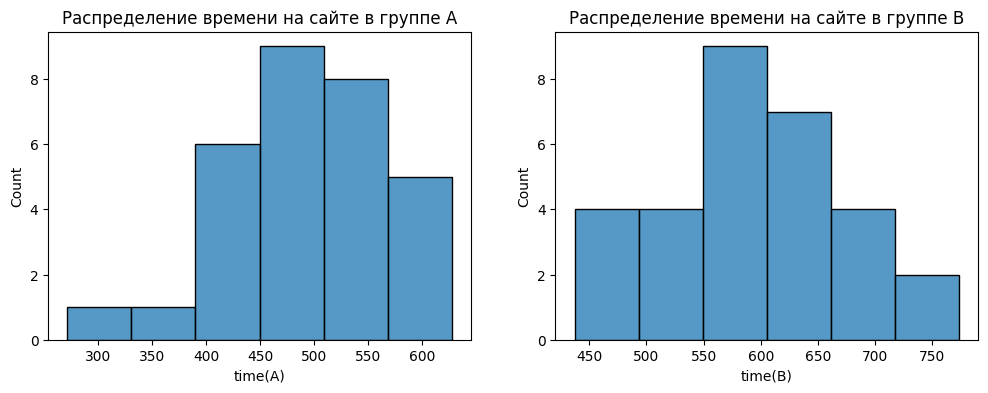

In [35]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

In [36]:
# Гистограммы напоминают нормальное распределение. 
# Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро — Уилка. 
# Для этого используем функцию shapiro() из модуля scipy.stats:

from scipy.stats import shapiro

Зададим уровень значимости  и проверим гипотезу о нормальности каждого из распределений (нулевая гипотеза — распределение нормальное, альтернативная — распределение отлично от нормального):

In [37]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")


p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, чтобы сравнить среднее время посещения сайта в группах.

Напомним формулировки статистических гипотез для T-теста:
- Нулевая гипотеза (об отсутствии эффекта): среднее время, которое проводят на сайте пользователи из группы А, равно среднему времени, которое проводят на сайте пользователи из группы B:
- Альтернативная гипотеза (о наличии эффекта): среднее время, которое проводят на сайте пользователи из группы А, отличается от среднего времени, которое проводят на сайте пользователи из группы B:

Примечание. Ещё раз обратите внимание на то, что именно альтернативная гипотеза отвечает на бизнес-вопрос «Увеличилось ли время, которое пользователь проводит на сайте, после внедрения варианта B?».

Применим двухвыборочный T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats.

In [38]:
from scipy.stats import ttest_ind

Функция принимает на вход следующие параметры:

- a и b — выборки, соответствующие каждой из групп.
- alternative — вид альтернативной гипотезы (‘two-sided’ — двусторонняя, 'less' — левосторонняя, 'greater’ — правосторонняя). По умолчанию используется двусторонняя гипотеза.

In [42]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Итак, в результате проведения T-теста мы получили p-value = 0, что меньше, чем уровень значимости 0.05. Это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной.

Что это значит для нас и для бизнеса?

Так как истинные значения конверсий в группах не равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза подтверждается статистически.

Переводим на язык бизнеса: существует разница между вариантами дизайна сайта по метрике времени, которое пользователь проводит на сайте. На основе данных мы видим, что тёмная тема более привлекательна для посетителей, чем светлая.
Обратите внимание: так как при двусторонней гипотезе p-value = 0, не нужно проверять одностороннюю гипотезу о том, что среднее время, которое проводят на сайте пользователи из группы A, меньше, чем среднее время для пользователей из группы B. Мы можем сделать итоговый вывод об этом только на основе данных, ведь мы доказали статистическую значимость разницы в метриках. Однако при желании вы можете проверить одностороннюю гипотезу самостоятельно — для этого в функции установите параметр alternative='less'.

#### НЕПАРАМЕТРИЧЕСКИЕ ТЕСТЫ

Давайте рассмотрим ещё один пример.

Мы проводим A/B-тест, чтобы оценить, влияет ли наличие рекомендательной системы сопутствующих товаров на средний чек покупки. Гипотеза заключается в том, что рекомендательная система мотивирует пользователей, помимо основных товаров, добавлять в покупку сопутствующие, тем самым повышая средний чек. Уровень значимости равен 0.05.

In [43]:
check_data = pd.read_excel('data/check_data.xlsx')
check_data.head()

,date,mean_check_a,mean_check_b
0,2020-11-06,68701.239649,88665.123322
1,2020-11-07,26136.309375,46230.394893
2,2020-11-08,119470.770656,139356.451490
3,2020-11-09,71110.880188,90867.073191
4,2020-11-10,85896.024022,105977.473589


В данных содержится информация о значениях ежедневного среднего чека в группах A и B. Период проведения A/B-тестирования — 18 дней.

Сначала сравним среднее время в группах на глаз. Рассчитаем среднее и медианное время в каждой группе:

In [44]:
check_data[['mean_check_a', 'mean_check_b']].agg(['mean', 'median'])

,mean_check_a,mean_check_b
mean,76684.763071,96658.897304
median,62883.707793,82854.201467


По предварительным подсчётам, ежедневный средний чек в группе B выше, чем в группе A. Однако делать выводы ещё рано — необходимо определить статистическую значимость полученных результатов.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


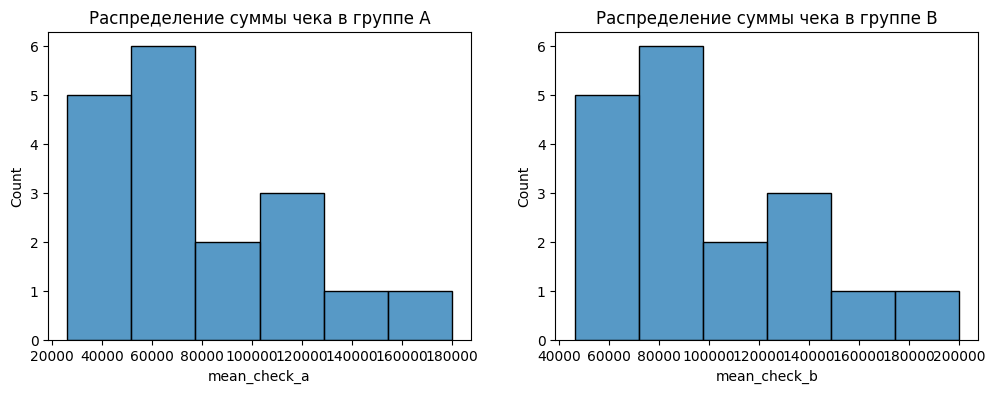

In [45]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean_check_a', data=check_data, ax=axes[0])
sns.histplot(x='mean_check_b', data=check_data, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение суммы чека в группе А');
axes[1].set_title('Распределение суммы чека в группе B');

Распределения не являются нормальными. Можно проверить это с помощью теста Шапиро — Уилка, однако мы опустим этот шаг (при желании вы можете сделать это самостоятельно). Формы распределений больше напоминают логнормальные: большинство наблюдений сосредоточено около нуля, и частота постепенно падает.

Итак, поскольку данные не распределены нормально, для сравнения истинных средних чеков T-тест уже нё подойдет. Здесь нам придётся обратиться к непараметрическим тестам, например, к критерию Манна — Уитни (U-тест), критерию Колмогорова — Смирнова и другим. Напомним, что эта категория тестов применяется в случаях, когда нет информации о распределении.

Давайте воспользуемся тестом Манна — Уитни, чтобы проверить, статистически значима ли разница ежедневных средних чеков для двух вариантов рекомендательной системы.

Для критерия Манна — Уитни гипотезы будут выглядеть следующим образом:
- Нулевая гипотеза (об отсутствии эффекта): распределение, лежащее в основе среднего чека в группе А, идентично распределению, лежащему в основе среднего чека в группе B
- Альтернативная гипотеза (о наличии эффекта): распределение, лежащее в основе среднего чека в группе А, отлично от распределения, лежащего в основе среднего чека в группе B:

In [46]:
# Напомним, что U-тест Манна — Уитни реализован в функции mannwhitneyu() из модуля scipy.stats.

from scipy.stats import mannwhitneyu

Функция принимает на вход следующие параметры:
- x и y — выборки, соответствующие каждой из групп.
- alternative — вид альтернативной гипотезы (‘two-sided’ — двусторонняя, 'less' — левосторонняя, 'greater’ — правосторонняя). По умолчанию используется двусторонняя гипотеза.

In [47]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.06
У нас нет оснований отвергнуть нулевую гипотезу


Итак, согласно результатам тестирования, p-value = 0.06, что больше, чем уровень значимости . Значит, у нас нет оснований отвергнуть нулевую гипотезу.

Что это значит для нас и для бизнеса?

Средние чеки в группах А и B статистически равны между собой. Отсюда можно сделать бизнес-вывод, что рекомендательная система не влияет на мотивацию пользователей добавлять сопутствующие товары в корзину.

Однако нас должно насторожить, что p-value очень близко к уровню значимости. Поэтому давайте дополнительно проведём односторонний U-тест со следующими гипотезами:
- Нулевая гипотеза (об отсутствии эффекта): распределение, лежащее в основе среднего чека в группе А, статистически больше либо равно распределению, лежащему в основе среднего чека в группе B:
- Левосторонняя альтернативная гипотеза (о наличии эффекта): распределение, лежащее в основе среднего чека в группе А, статистически меньше распределения, лежащего в основе среднего чека в группе B:

In [48]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='less' # изменили альтернативную гипотезу
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.03
Отвергаем нулевую гипотезу в пользу альтернативной


Получаем значение p-value = 0.03, что меньше, чем уровень значимости . Значит, мы должны отвергнуть нулевую гипотезу в пользу альтернативной. Таким образом, односторонний тест говорит нам, что разница в средних чеках всё-таки статистически значима. То есть рекомендательная система всё-таки мотивирует пользователей добавлять сопутствующие товары в корзину и повышает средний чек, а значит, её можно внедрять для всех пользователей сайта.

Итак, мы получили два противоречивых вывода: двусторонний тест говорит, что эффекта нет, а односторонний — что есть. Какой вывод правильный?

На самом деле никакой. Когда двусторонний и односторонний тесты противоречат друг другу, это, скорее всего, означает, что данные неоднозначны и нужно более внимательно исследовать результаты тестирования.

В такой ситуации для более точной оценки эффекта можно попробовать провести анализ данных с помощью других методов и моделей. Также стоит обратить внимание на размер выборки, возможные выбросы, несбалансированность групп, а также на то, были ли учтены все факторы, которые могут влиять на результаты тестирования.

В нашем случае очевидной проблемой является размер выборки, а точнее длительность A/B-теста. Замеры среднего чека сделаны только за 18 дней, что очень мало. Размер выборки играет важную роль, особенно при применении непараметрических тестов (каким является тест Манна — Уитни), которые обладают меньшей мощностью, чем параметрические, а потому требуют большего количества наблюдений.

Таким образом, в данном случае мы не можем принять решение о внедрении или невнедрении рекомендательной системы, так как у нас попросту недостаточно данных, чтобы сделать вывод. Необходимо продолжить A/B-тестирование, чтобы получить однозначные результаты.

### Задание 5.2 - 5.4

С помощью Z-теста для пропорций проанализируйте результаты проведённого A/B-тестирования и определите, какой из вариантов дизайна (A или B) более предпочтителен по метрике конверсии. В качестве уровня значимости возьмите альфа 0.05. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion.

Какой вывод можно сделать на основании результатов тестирования?

Нулевая (об отсутствии эффекта): конверсии в группах A и B равны.

Альтернативная (о наличии эффекта): конверсии в группах A и B не равны.

In [49]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=[sample_a['transactions'].sum(), sample_b['transactions'].sum()], # число «успехов»
    nobs=[sample_a['cid'].count(), sample_b['cid'].count()], # общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.44
У нас нет оснований отвергнуть нулевую гипотезу


In [50]:
# Давайте вычислим ежедневный средний чек — это ежедневная сумма заказов, делённая на ежедневную сумму транзакций:

daily_sample_a = sample_a.groupby('date')[['transactions', 'revenue']].sum()
daily_sample_a['mean_check'] = daily_sample_a['revenue']/daily_sample_a['transactions']
daily_sample_b = sample_b.groupby('date')[['transactions', 'revenue']].sum()
daily_sample_b['mean_check'] = daily_sample_b['revenue']/daily_sample_a['transactions']

Задание 5.3

Проверьте гипотезу о нормальности распределений ежедневного среднего чека в контрольной и тестовой группах с помощью критерия Шапиро — Уилка. В качестве уровня значимости возьмите альфа = 0.05.

Каковы результаты тестирования?

In [51]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(daily_sample_a['mean_check'])
shapiro_result_b = shapiro(daily_sample_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

p-value группы А 0.01
p-value группы B 0.03
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального


Задание 5.4

С помощью критерия Манна — Уитни проанализируйте результаты проведённого A/B-тестирования и определите, какой из вариантов дизайна (A или B) более предпочтителен по метрике ежедневного среднего чека. В качестве уровня значимости возьмите 0.05. Используйте функцию mannwhitneyu() из модуля scipy.stats.

Каков результат тестирования?

In [52]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=daily_sample_a['mean_check'],
    y=daily_sample_b['mean_check'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.12
У нас нет оснований отвергнуть нулевую гипотезу


# 6. Анализ результатов A/B-тестирования: доверительные интервалы

In [53]:
from scipy.stats import norm

n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

def z_mean_conf_interval(x_mean, sigma, n, gamma=0.95):  
    alpha = 1 - gamma  # уровень значимости
    z_crit = -norm.ppf(alpha/2)  # z-критическое
    eps = z_crit * sigma/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps  # левая (нижняя) граница
    upper_bound = x_mean + eps  # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# строим доверительный интервал для среднего при известном СКО
lower_bound, upper_bound = z_mean_conf_interval(x_mean, sigma, n)

# выводим результат
print('Доверительный интервал: {}'.format((round(lower_bound), round(upper_bound))))

Доверительный интервал: (12180, 20020)


Примечание. Заметьте, что это универсальный код. Если перед вами возникнет другая задача расчёта доверительного интервала для истинного среднего, то вам достаточно будет правильно поменять значения переменных.

Полученный результат интерпретируется следующим образом: мы на 95 % уверены, что истинные расходы жителей на продукты питания лежат в интервале от 12 180 рублей до 20 020 рублей. 

Чтобы построить доверительный интервал для среднего при известном стандартном отклонении, можно использовать функцию norm.interval() из модуля norm библиотеки scipy. В неё нужно нужно передать следующие параметры:

- confidence — уровень надёжности ;
- loc — центр интервала (выборочное среднее);
- scale — погрешность (стандартное отклонение, нормированное на ).


In [54]:
# Пример вызова функции:

# строим доверительный интервал
lower, upper = norm.interval(gamma, loc=x_mean, scale=sigma / n**0.5)
print('Доверительный интервал: {}'.format((round(lower), round(upper))))

Доверительный интервал: (12180, 20020)


⚡ Важно! Доверительный интервал не даёт нам 100 % результата. Всегда есть шанс, что мы промахнулись и не захватили истинного значения. Этот шанс как раз равен уровню значимости .
То есть в нашем примере существует 5 %-ый шанс, что истинное среднее расходов вовсе не лежит в интервале от 12 180 до 20 020. Существует вероятность, что математическое ожидание на самом деле равно 5 000 рублей или 25 000 рублей. Но такая вероятность составляет менее 5 %, и это нас устраивает.

Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

In [57]:
n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.90 # уровень надёжности
alpha = 1 - gamma # уровень значимости

lower, upper = norm.interval(gamma, loc=x_mean, scale=sigma / n**0.5)
print('Доверительный интервал: {}'.format(((lower), (upper))))
z_crit = -norm.ppf(alpha/2)
z_crit

Доверительный интервал: (11.856543911914558, 12.843456088085441)


1.6448536269514729

#### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ НЕИЗВЕСТНОМ СТАНДАРТНОМ ОТКЛОНЕНИИ
✏️ А теперь давайте решим задачу!

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.

Давайте поможем управляющему, решив несколько задачек с помощью Python.

Итак, зададим необходимые для решения задачи переменные:

In [58]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [59]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое
print(t_crit)

2.1447866879169273


In [60]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# cтроим доверительный интервал для среднего при неизвестном СКО
lower_bound, upper_bound = t_mean_conf_interval(x_mean, x_std, n)

# выводим результат
print('Доверительный интервал: {}'.format((round(lower_bound), round(upper_bound))))

Доверительный интервал: (1778, 2222)


Итак, мы на 95 % уверены, что истинные траты покупателей в нашем магазине лежат в интервале от 1 778 до 2 222 рублей.

Чтобы построить доверительный интервал для среднего при неизвестном стандартном отклонении, можно использовать функцию t.interval() из модуля t библиотеки scipy. В неё нужно передать следующие параметры:
- confidence — уровень надёжности ;
- df — количество степеней свободы для распределения Стьюдента;
- loc — центр интервала (выборочное среднее);
- scale — погрешность нормированное стандартное отклонение

Пример вызова функции:

In [61]:
# строим доверительный интервал для среднего при неизвестном СКО
lower, upper = t.interval(gamma, df=k, loc=x_mean, scale=x_std/(n ** 0.5))
print('Доверительный интервал: {}'.format((round(lower), round(upper))))

Доверительный интервал: (1778, 2222)


Важно отметить, что при достаточной выборке (примерно более 30 наблюдений) распределение Стьюдента очень похоже на стандартное нормальное распределение. В этом случае можно использовать первую формулу (z-критическое) даже при неизвестном стандартном отклонении. Однако используя вторую формулу при оценке среднего, вы не ошибётесь.

Ещё один важный факт состоит в том, что обе формулы работают только при соблюдении двух условий:

- Выборка должна быть случайной.
- Выборка должна быть достаточно велика. Но есть исключение: если выборка маленькая, но сама величина распределена нормально, то выборочное среднее тоже будет распределено нормально. В таком случае мы можем пользоваться формулой доверительного интервала.

Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540. Также известно выборочное отклонение величины подоходного налога, равное $ 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.

Укажите границы построенного доверительного интервала для истинного среднего. Ответ округлите до целого.

In [65]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

lower, upper = t.interval(gamma, df=k, loc=x_mean, scale=x_std/(n ** 0.5))
print('Доверительный интервал: {}'.format((round(lower), round(upper))))

Доверительный интервал: (3146, 3934)


#### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ

In [66]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [67]:
# Для удобства создадим отдельные таблицы для каждой из групп пользователей:

# фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
# фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

Давайте на этот раз оформим расчёт в виде функции: объявим функцию proportion_conf_interval(). У данной функции будет три аргумента: x_p — выборочная пропорция, n — размер выборки и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой.

In [68]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [69]:
# Теперь применим нашу функцию к данным группы А и группы B, результат умножим на 100 % и округлим до сотых:

# строим доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=a_data['converted'].mean(), # выборочная пропорция
    n=a_data['user_id'].count() # размер выборки
)

# строим доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=b_data['converted'].mean(), # выборочная пропорция
    n=b_data['user_id'].count() # размер выборки
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.86, 12.19)
Доверительный интервал для конверсии в группе B: (11.7, 12.03)


Итак, можно сделать вывод, что с надёжностью в 95 % конверсия группы А лежит в интервале от 11.86 % до 12.19 %, а конверсия группы B лежит в интервале от 11.7 % до 12.03 %.

Вычисление доверительного интервала можно было реализовать с помощью библиотечных инструментов, например, функцией proportion.proportion_confint() из модуля stats библиотеки statsmodels. Функция принимает на вход следующие аргументы:
- count — количество успехов (в нашем случае это суммарное количество пользователей, выполнивших целевое действие);
- nobs — количество наблюдений;
- alpha — уровень значимости.

Пример вызова функции:

In [70]:
from statsmodels.stats import proportion

# вычисляем доверительный интервал для конверсии в группе A с уровнем доверия 0.95
lower_bound_a, upper_bound_a = proportion.proportion_confint(
    count=a_data['converted'].sum(),
    nobs=a_data['user_id'].count(),
    alpha=0.05
)

# вычисляем доверительный интервал для конверсии в группе B с уровнем доверия 0.95
lower_bound_b, upper_bound_b = proportion.proportion_confint(
    count=b_data['converted'].sum(),
    nobs=b_data['user_id'].count(),
    alpha=0.05
)
# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.86, 12.19)
Доверительный интервал для конверсии в группе B: (11.7, 12.03)


Если схематично изобразить построенные доверительные интервалы для конверсии в группах А и B, можно отчётливо заметить пересечение интервалов.

Что значит такое пересечение интервалов для нас? Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть. То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Можно даже рассчитать эту вероятность, но лучше пойти другим путём.

Лучше построить доверительный интервал разницы пропорций (конверсий).

✏️ Создадим функцию diff_proportion_conf_interval() со следующими аргументами: x_p — список из выборочных пропорций для групп А и B соответственно,  n — список из размеров выборки для групп А и B соответственно, и gamma — уровень надёжности (по умолчанию он равен 0.95). Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [71]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [72]:
# Вызовем функцию и построим интересующий нас доверительный интервал:

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [a_data['converted'].mean(), b_data['converted'].mean()]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Итак, что можно сказать теперь? Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %. 

То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

В заключение хотелось бы отметить, что доверительный интервал для пропорции применяется не только для оценки конверсии и разницы конверсий в группах!

Под истинной пропорцией может пониматься доля успешно угаданных моделью объектов (accuracy), доля выздоровевших пациентов или доля ушедших клиентов (отток). То есть такой доверительный интервал может быть применён в любой задаче A/B-тестирования, где признак, по которому считается метрика, бинарный (имеет два возможных исхода — «успех» и «неуспех»). А это очень большой спектр задач!

Таким образом, доверительные интервалы — это ещё один вспомогательный инструмент проведения A/B-тестирования, который позволяет с определённой заранее надёжностью статистически сравнить варианты продукта А и B по заданной метрике. 

⭐️ Обычно доверительные интервалы используются в комплексе со статистическими тестами. Статистический тест показывает, значимы ли наши результаты, а доверительный интервал показывает пределы изменения метрик и их разницы в группах. 